# **Section Project 2**

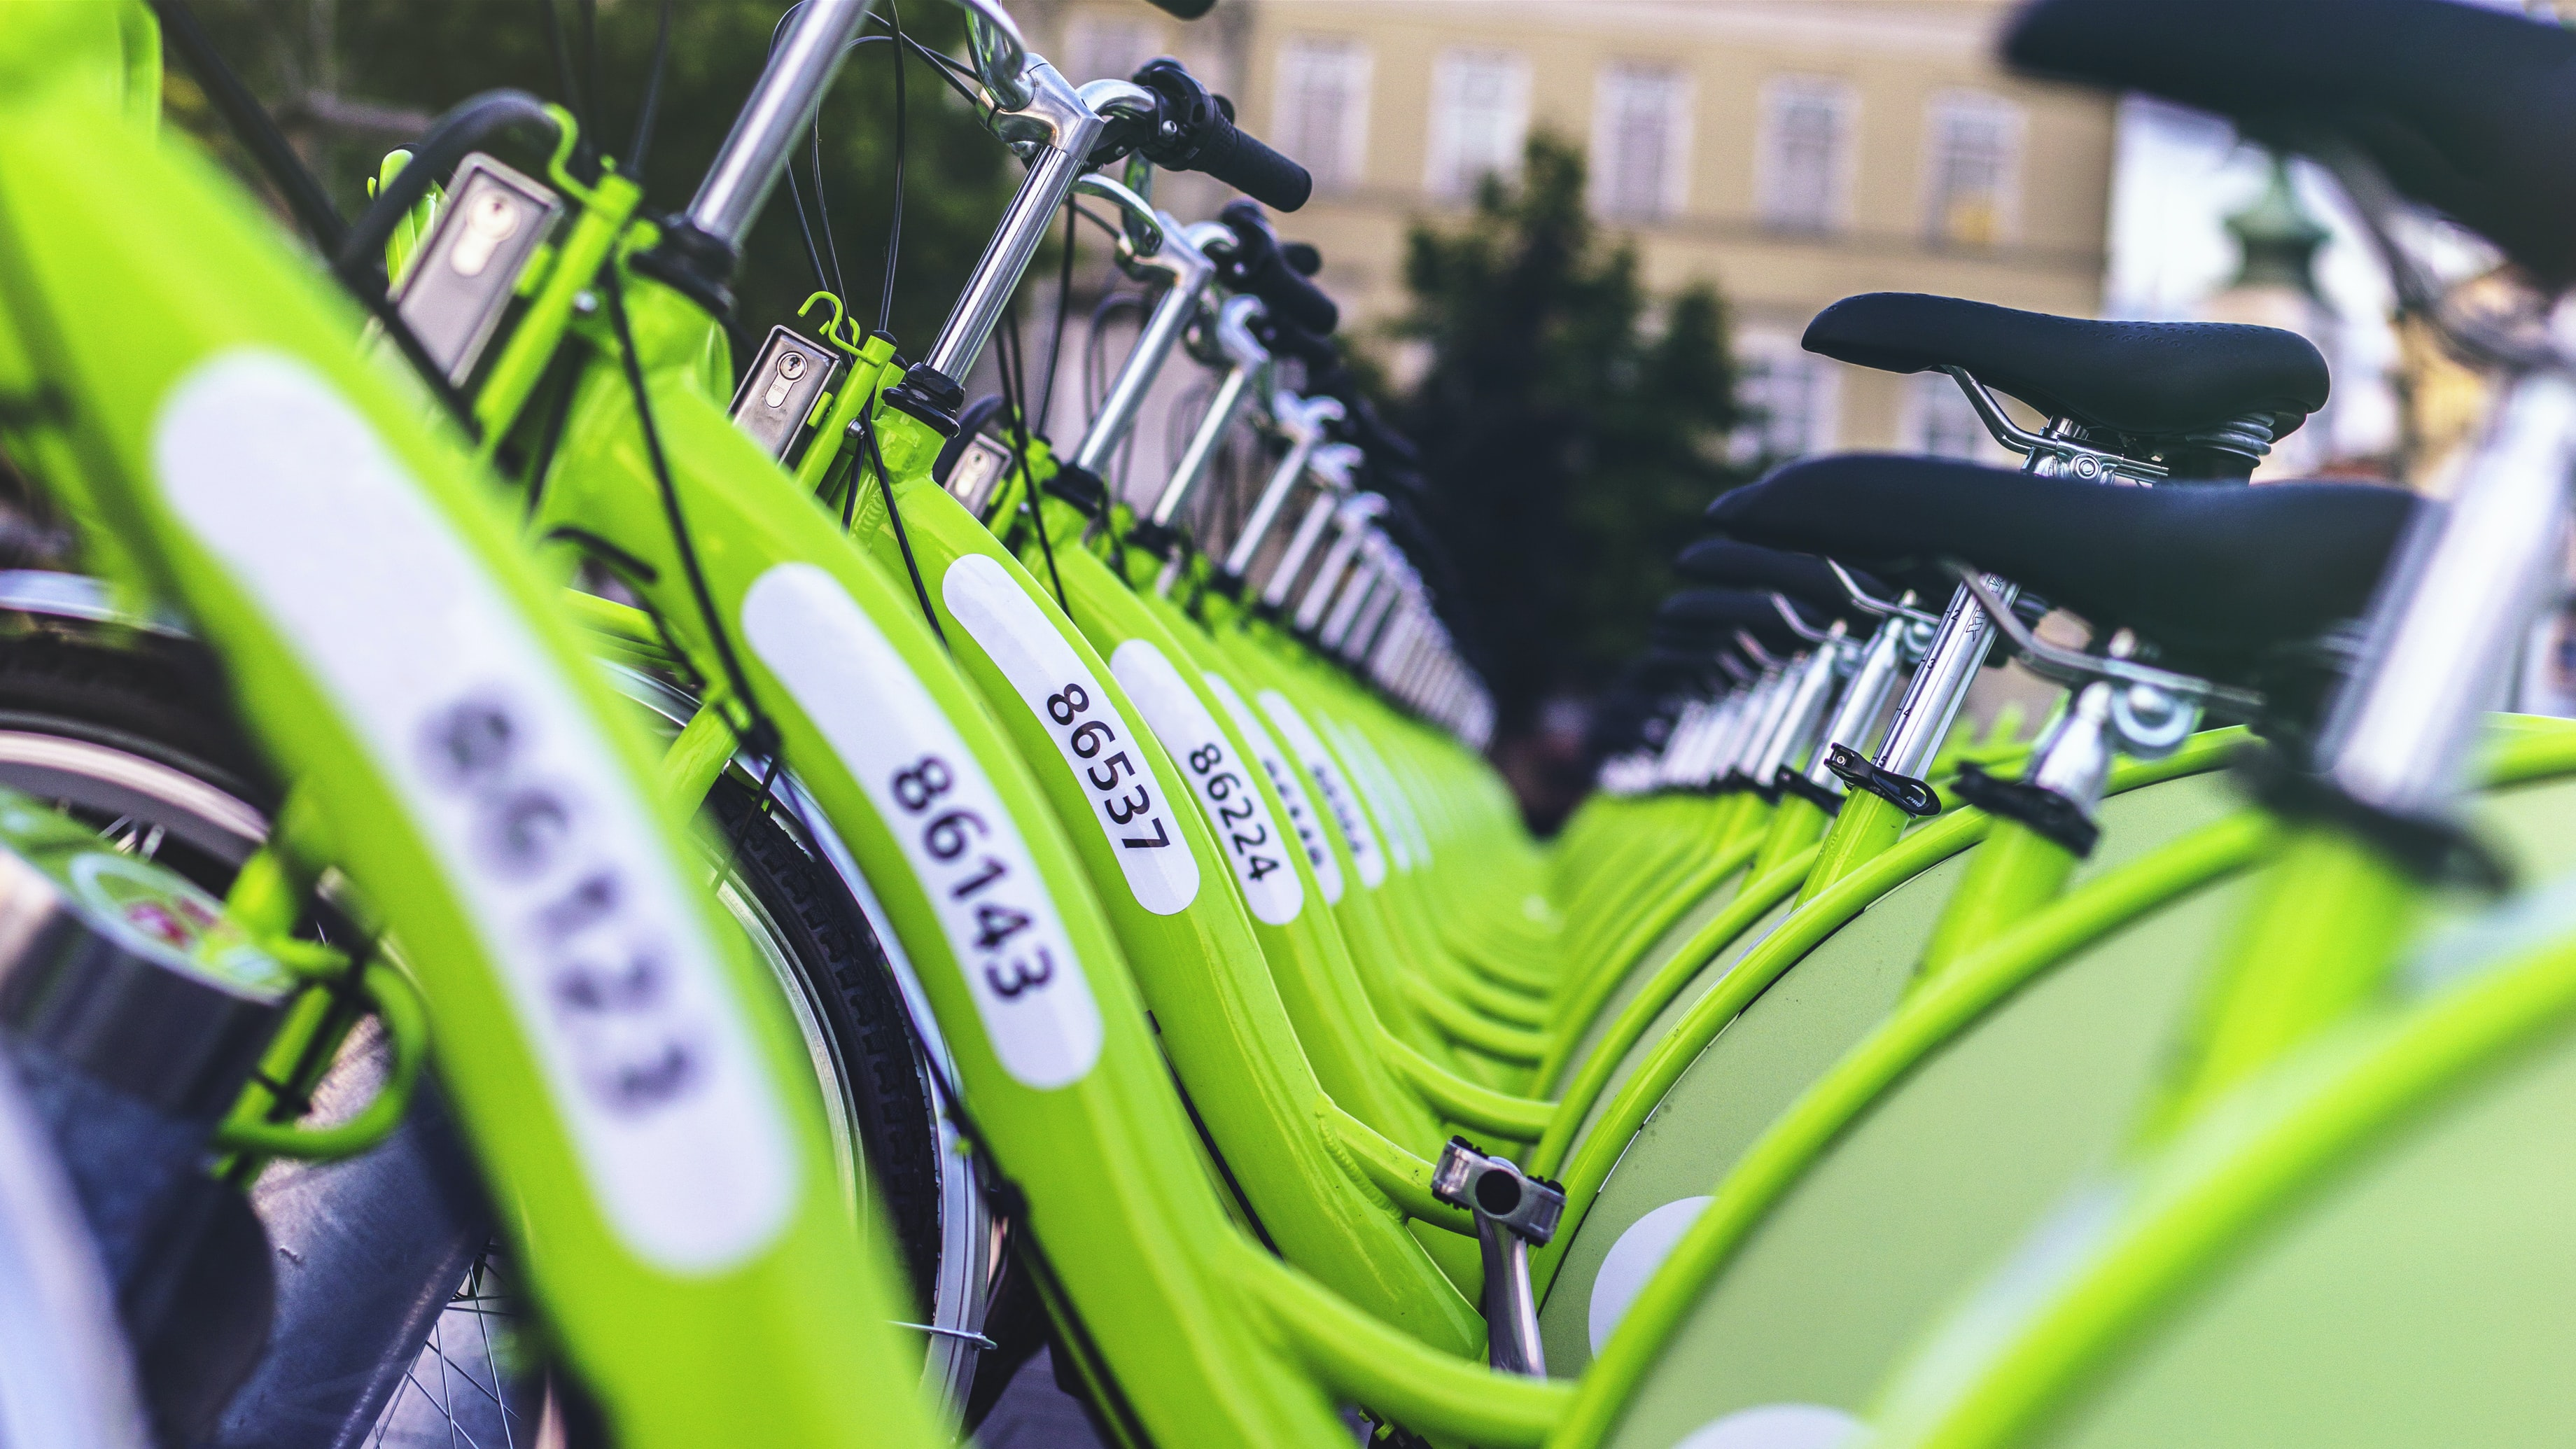
## Goal: 자전거의 공유량 예측하기
공유 자전거(ex. 서울시의 따릉이)의 공유량을 예측할 수 있다면 관리/감독이 용이
공유량에 영향을 주는 요인?
> 맑음 vs. 비, 낮 vs. 밤, 평일 vs. 주말

가설:요인(시기, 날씨, 시간 등)에 따른 공유량은 특정한 패턴에 따라 변화할 것이다.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install pdpbox shap eli5

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from pdpbox.pdp import pdp_isolate, pdp_plot
import shap
import eli5
from eli5.sklearn import PermutationImportance

## **1. 데이터 준비하기**
#### Data: London bike sharing dataset(https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset)

### **컬럼 설명**
* timestamp: 날짜 및 시간
* cnt: 1시간당 새롭게 공유된 자전거 수
* t1: 실제 온도(℃)
* t2: 체감 온도(℃)
* hum: 습도(%)
* wind_speed: 풍속(km/h)
* weather_code: 날씨(1 = 맑음 / 2 = 구름 적음 / 3 = 구름 보통 / 4 = 구름 많음 / 7 = 비, 약한 소나기 / 10 = 뇌우를 동반한 비 / 26 = 눈 / 94 = 착빙성 안개)
* is_holiday: 1=연휴 / 0=연휴x
* is_weekend: 1=주말 / 0=주말x
* season: 계절(0 = 봄(3-5월) / 1 = 여름(6-8월) / 2 = 가을(9-11월) / 3 = 겨울(12-2월))

In [2]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/AI 부트캠프/Section Project/Section 2/london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## >> cnt를 타겟으로 하는 회귀문제로 접근
* 평가지표: Mean Absolute Error(평균 절대 오차), R2 score
* 기준모델: 평균

## **2. EDA & Pre-Processing**

In [3]:
# 결측치와 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
# 범주형 변수들의 타입을 정수형으로 변경
df.weather_code = df.weather_code.astype(int)
df.is_holiday = df.is_holiday.astype(int)
df.is_weekend = df.is_weekend.astype(int)
df.season = df.season.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  int64  
 7   is_holiday    17414 non-null  int64  
 8   is_weekend    17414 non-null  int64  
 9   season        17414 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.3+ MB


In [5]:
# 중복값 확인
df.duplicated().sum()

0

#### *1) 타겟의 분포 확인*

<Figure size 360x360 with 0 Axes>

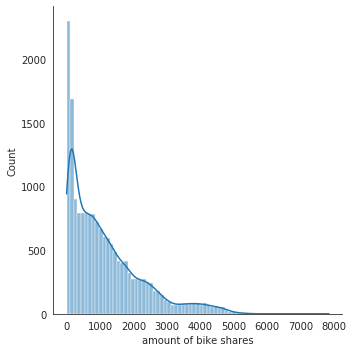

In [6]:
# 타겟의 분포 확인 -> 왼쪽으로 치우친 형태
sns.set_style('white')
plt.figure(figsize=(5,5))
sns.displot(df['cnt'], kde=True)
plt.xlabel('amount of bike shares');

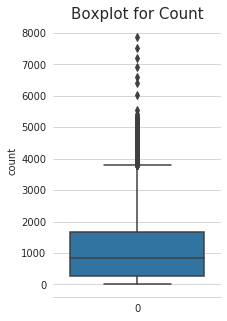

In [7]:
# boxplot으로 타겟의 이상치 확인
sns.set_style('whitegrid')
plt.figure(figsize=(3,5))
sns.boxplot(data=df['cnt'])
sns.despine(left=True)
plt.title('Boxplot for Count', fontsize=15)
plt.ylabel('count');

#### *2) 상관관계 살펴보기*

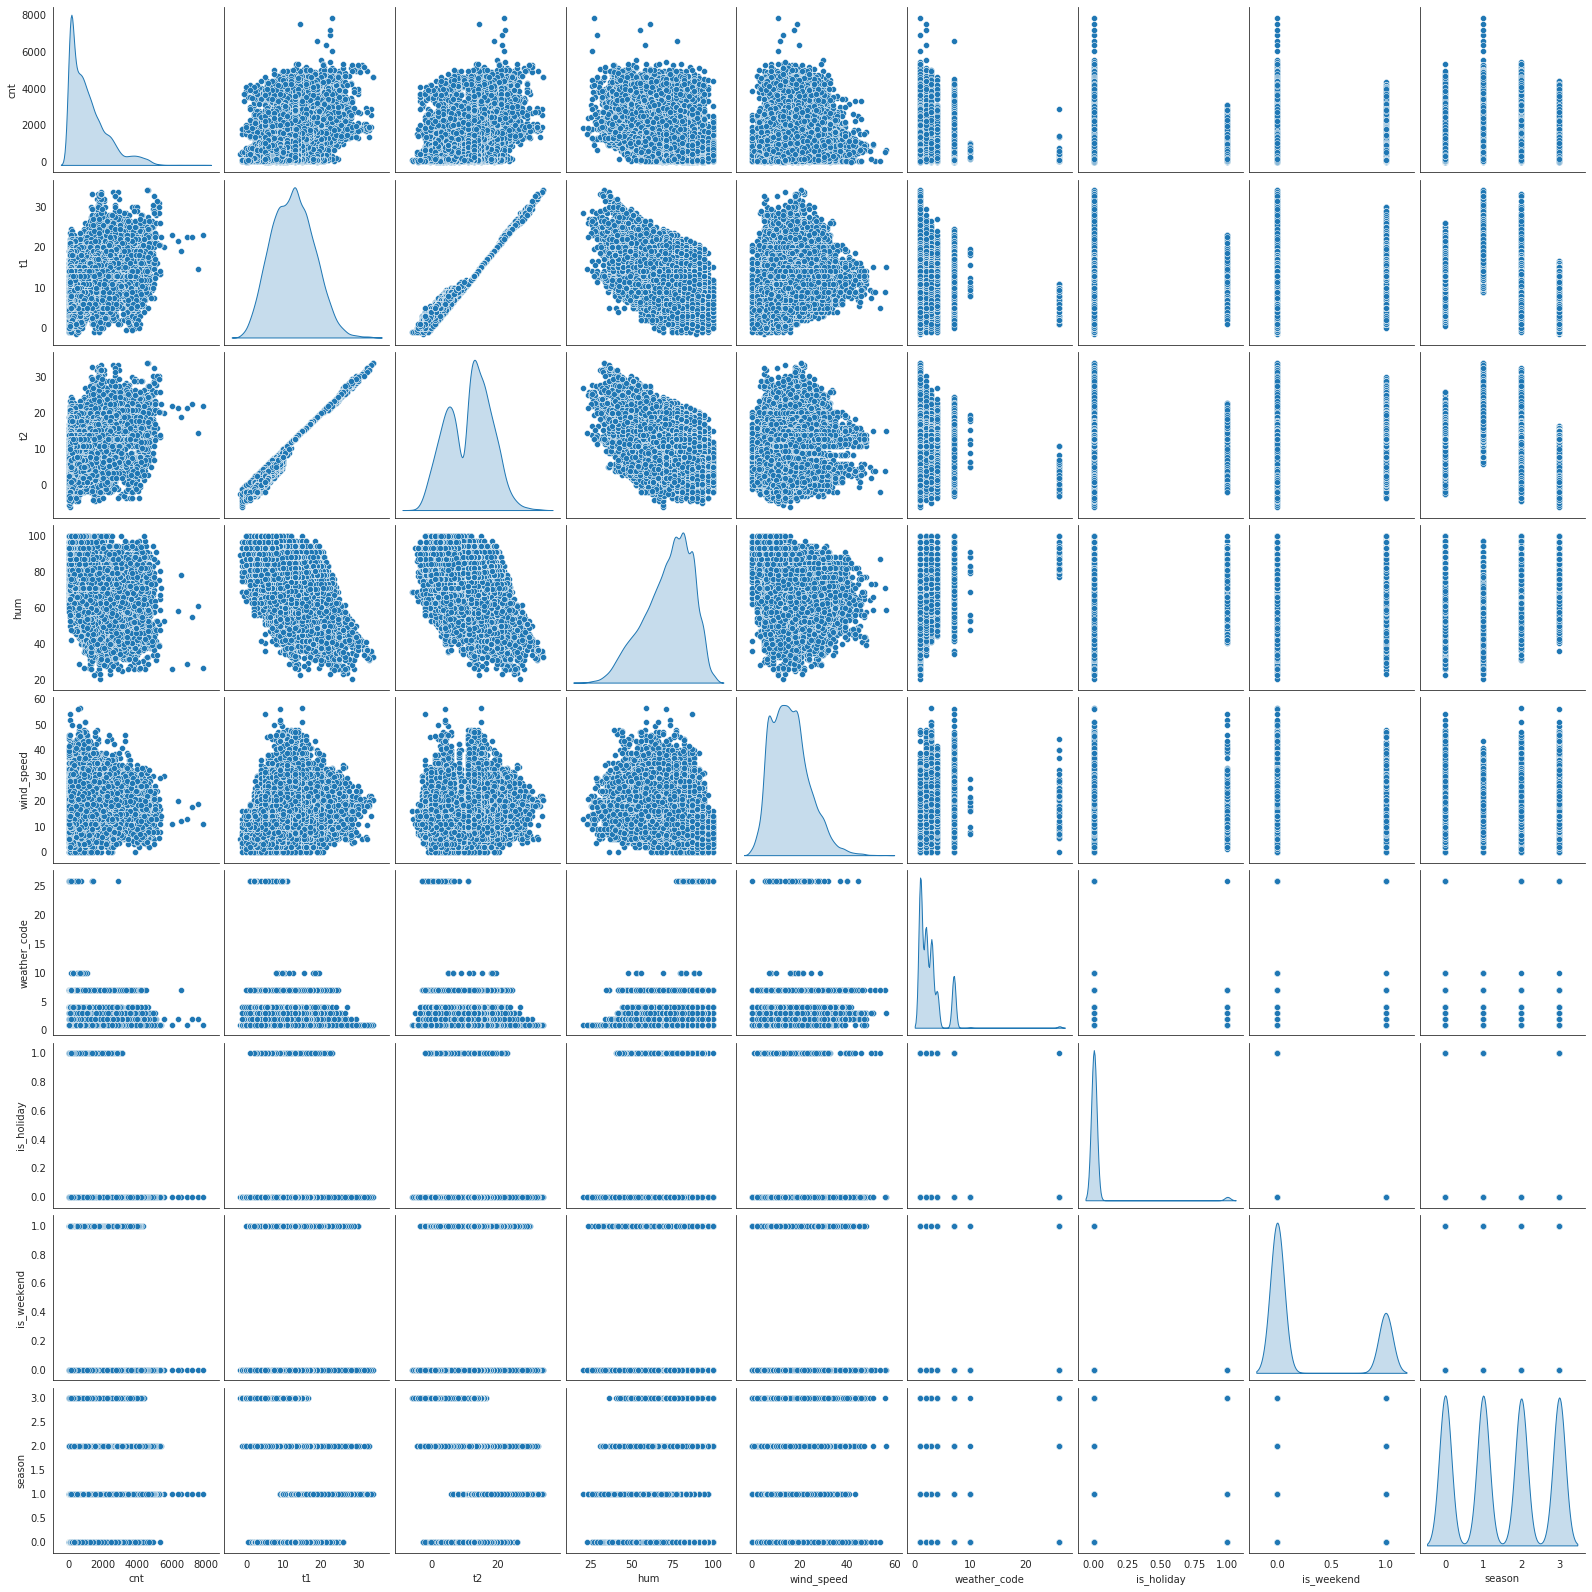

In [8]:
# 상관관계 살펴보기 -> t1과 t2의 상관관계가 높음(다중공선성)
sns.set_style('white')
sns.pairplot(df, diag_kind='kde');

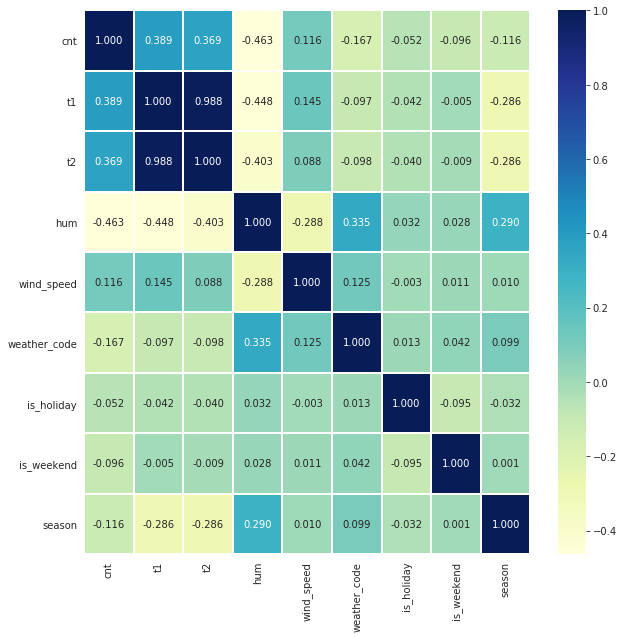

In [12]:
# 상관관계를 히트맵으로 시각화해보기
plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(), annot=True, fmt='.3f' ,linewidths=1, cmap='YlGnBu')
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5);

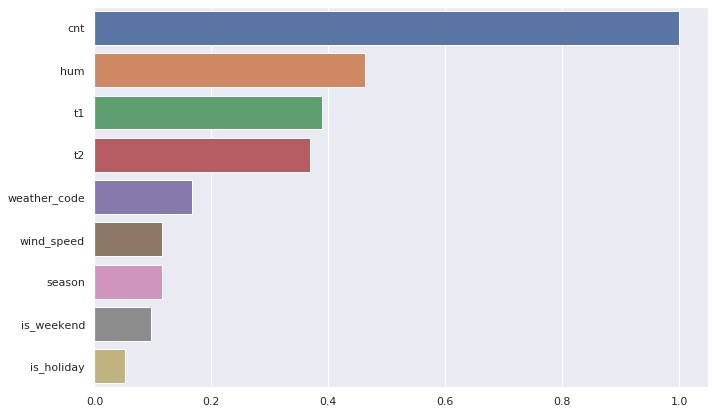

In [13]:
# 타겟과의 상관관계
sns.set_theme()
plt.figure(figsize=(11,7))
sns.barplot(data=abs(df.corr()[['cnt']]).sort_values(by='cnt', ascending=False).T, orient='h');

#### *3) 컬럼별로 데이터 확인해보기*

In [14]:
# 문자열 형태였던 timestamp 컬럼을 datetime으로 변경하여 pandas가 날짜와 시간을 이해할 수 있게 변경
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3


In [15]:
# 인덱스에서 필요한 정보들을 추출
df['year_month'] = df.index.strftime('%Y - %m')
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_week']  = df.index.dayofweek
df['hour'] = df.index.hour
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year_month,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3,2015 - 01,2015,1,4,6,0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3,2015 - 01,2015,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3,2015 - 01,2015,1,4,6,2
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3,2015 - 01,2015,1,4,6,3
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3,2015 - 01,2015,1,4,6,4


* 온도, 습도, 풍속에 따른 공유량

> 온도가 증가할수록 공유량 증가

> 습도가 증가할수록 공유량 감소

> 풍속에 따라서는 패턴 확인 불가

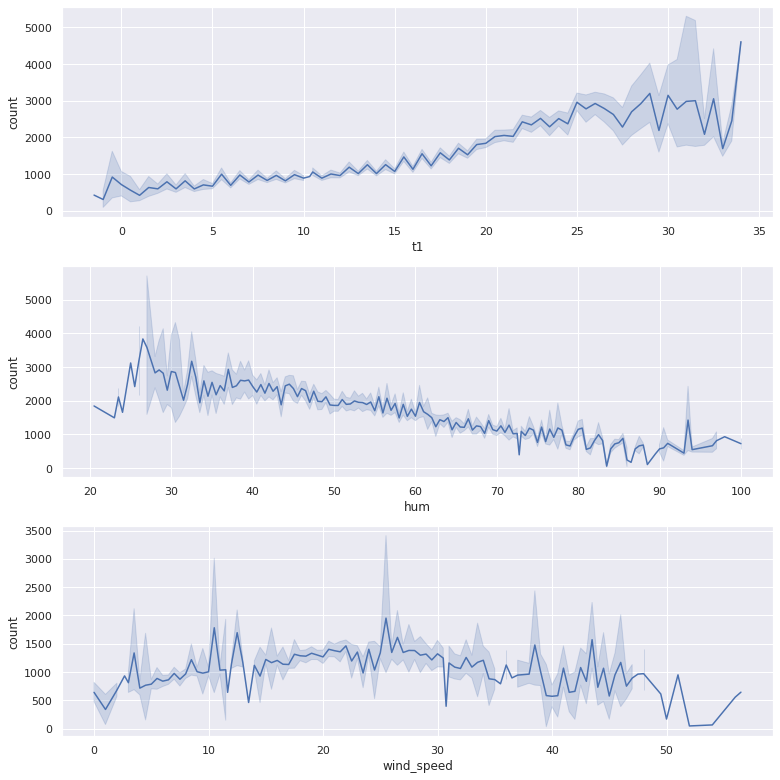

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(11,11))
ax1 = sns.lineplot(x='t1', y='cnt', data=df, ax=axs[0])
ax2 = sns.lineplot(x='hum', y='cnt', data=df, ax=axs[1])
ax3 = sns.lineplot(x='wind_speed', y='cnt', data=df, ax=axs[2])

ax1.set_ylabel('count')
ax2.set_ylabel('count')
ax3.set_ylabel('count')
plt.tight_layout()

* 날씨와 계절에 따른 공유량

> 날씨가 비교적 좋을수록 공유량이 많음</br>
weather code: 1 = 맑음 / 2 = 구름 적음 / 3 = 구름 보통 / 4 = 구름 많음 / 7 = 비, 약한 소나기 / 10 = 뇌우를 동반한 비 / 26 = 눈 / 94 = 착빙성 안개

> 여름이 가장 공유량이 많고, 겨울이 가장 적음</br>
season : 0 = 봄(3-5월) / 1 = 여름(6-8월) / 2 = 가을(9-11월) / 3 = 겨울(12-2월)

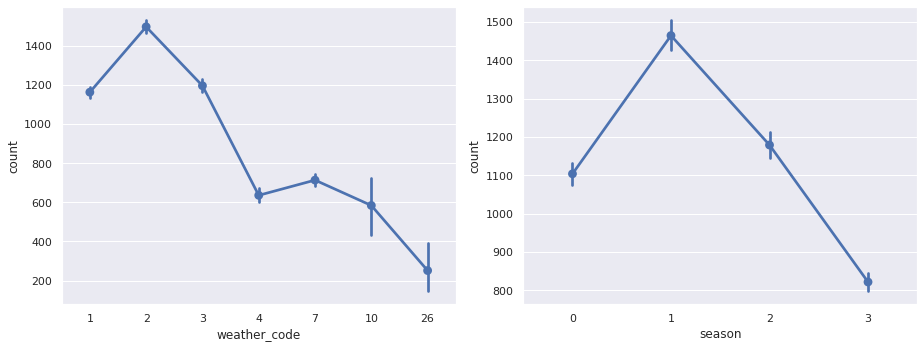

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
ax1 = sns.pointplot(x='weather_code', y='cnt', data=df, ax=axs[0])
ax2 = sns.pointplot(x='season', y='cnt', data=df, ax=axs[1])

ax1.set_ylabel('count')
ax2.set_ylabel('count')
plt.tight_layout()

* 일간, 주간 공유량

> 일간에서는 특별한 패턴 확인 불가

> 주간에서는 평일에 공유량이 많고, 주말에는 적음</br>
0: 월, 1: 화, 2: 수, 3: 목, 4: 금, 5: 토, 6: 일

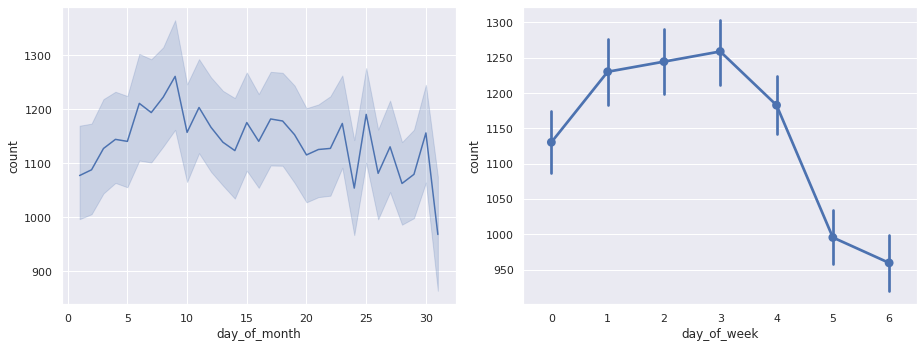

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
ax1 = sns.lineplot(x='day_of_month', y='cnt', data=df, ax=axs[0])
ax2 = sns.pointplot(x='day_of_week', y='cnt', data=df, ax=axs[1])

ax1.set_ylabel('count')
ax2.set_ylabel('count')
plt.tight_layout()

* 월간 공유량

> 7월에 가장 많고 1월에 가장 적음

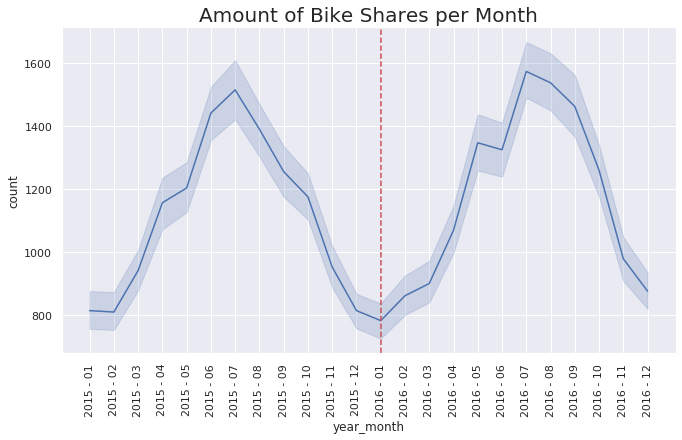

In [19]:
plt.figure(figsize=(11,6))
ax = sns.lineplot(x='year_month', y='cnt', data=df[df['year_month']<='2016 - 12'])
plt.axvline(x='2016 - 01', color='r', ls='--')
plt.title('Amount of Bike Shares per Month', fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('count');

* 시간당 공유량

> 전체적으로 출퇴근 시간에 공유량이 많음

> 그러나 요일 특성을 나누어서 보면 평일(workdays)과 주말/연휴의 시간당 공유량 패턴이 다름

> 평일에는 출퇴근 시간이 공유량이 많고, 주말/연휴에는 낮시간 동안의 공유량이 많음

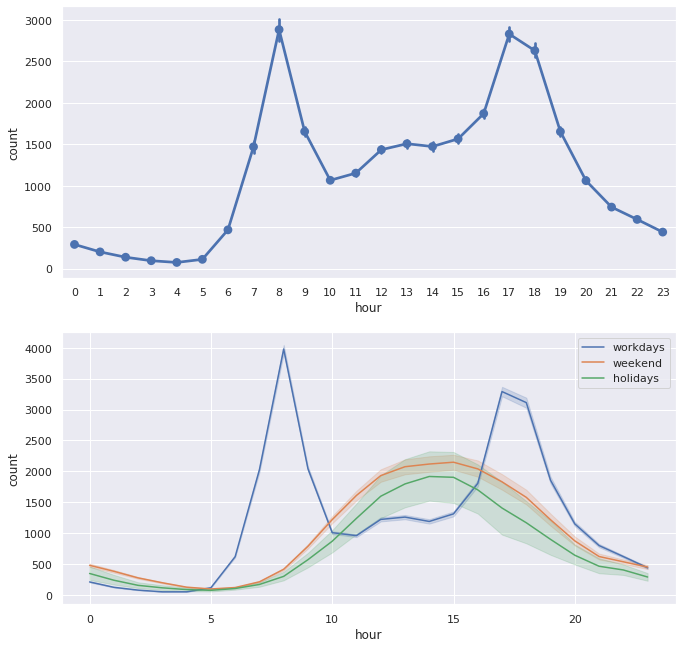

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(11,11))
ax1 = sns.pointplot(x='hour', y='cnt', data=df, ax=axs[0])
ax2 = sns.lineplot(x='hour', y='cnt', data=df[(df['is_weekend'] == 0) & (df['is_holiday'] == 0)], ax=axs[1])
ax2 = sns.lineplot(x='hour', y='cnt', data=df[(df['is_weekend'] == 1) & (df['is_holiday'] == 0)], ax=axs[1])
ax2 = sns.lineplot(x='hour', y='cnt', data=df[df['is_holiday'] == 1], ax=axs[1])

ax1.set_ylabel('count')
ax2.set_ylabel('count')
ax2.legend(['workdays', 'weekend', 'holidays'])

## **3. 모델 생성**

In [21]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year_month,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3,2015 - 01,2015,1,4,6,0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3,2015 - 01,2015,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3,2015 - 01,2015,1,4,6,2
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3,2015 - 01,2015,1,4,6,3
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3,2015 - 01,2015,1,4,6,4


In [22]:
# 다중공선성이 우려되는 컬럼, 필요없는 컬럼 삭제
df.reset_index(drop=True, inplace=True)
df.drop(['t2', 'year_month', 'year', 'month', 'day_of_month', 'day_of_week'], axis=1, inplace=True)
df.head()

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,182,3.0,93.0,6.0,3,0,1,3,0
1,138,3.0,93.0,5.0,1,0,1,3,1
2,134,2.5,96.5,0.0,1,0,1,3,2
3,72,2.0,100.0,0.0,1,0,1,3,3
4,47,2.0,93.0,6.5,1,0,1,3,4


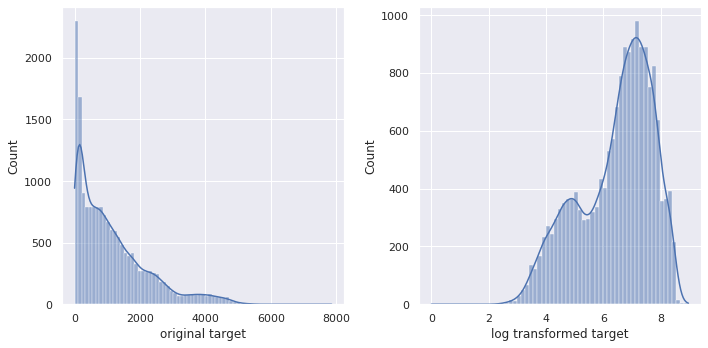

In [24]:
# 타겟의 분포가 왼쪽으로 치우쳐져 있으므로 학습에는 log 변환을 하여 사용 -> TransformedTargetRegressor
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax1 = sns.histplot(df['cnt'], ax=ax[0], kde=True);
ax2 = sns.histplot(np.log1p(df['cnt']), ax=ax[1], kde=True);

ax1.set_xlabel('original target')
ax2.set_xlabel('log transformed target')
plt.tight_layout()

In [25]:
# 학습, 검증, 테스트 세트로 나누기
train, test = train_test_split(df, train_size=0.8, random_state=10)
train, val = train_test_split(train, train_size=0.8, random_state=10)
train.shape, val.shape, test.shape

((11144, 9), (2787, 9), (3483, 9))

In [26]:
# 각 세트에서 특성들과 타겟을 구분하여 나누기
target = 'cnt'

X_train = train.drop(target, axis=1)
y_train = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11144, 8), (11144,), (2787, 8), (2787,), (3483, 8), (3483,))

#### *1) 기준모델* 

In [27]:
baseline = y_train.mean()
base_val = [baseline] * len(y_val)
base_pred = [baseline] * len(y_test)

print('Baseline Model:', baseline)
print('Validation MAE:', mean_absolute_error(y_val, base_val))
print('Validation R2 score:', r2_score(y_val, base_val))
print('Test MAE:', mean_absolute_error(y_test, base_pred))
print('Test R2 score:', r2_score(y_test, base_pred))

Baseline Model: 1146.5183955491746
Validation MAE: 852.3203312489971
Validation R2 score: -0.00031077852533734074
Test MAE: 841.6251791596101
Test R2 score: -2.3753362428102776e-06


#### *2) Ridge Regression*

In [28]:
ridge = Ridge(alpha=0.1,
              normalize=True,
              random_state=6)
tt1 = TransformedTargetRegressor(regressor=ridge,
                                 func=np.log1p,
                                 inverse_func=np.expm1)
tt1.fit(X_train, y_train)

ridge_val = tt1.predict(X_val)
ridge_pred = tt1.predict(X_test)

print('Train R2 score:', tt1.score(X_train, y_train))
print('Validation MAE:', mean_absolute_error(y_val, ridge_val))
print('Validation R2 score:', tt1.score(X_val, y_val))
print('Test MAE:', mean_absolute_error(y_test, ridge_pred))
print('Test R2 score:', r2_score(y_test, ridge_pred))

Train R2 score: 0.14865236676618365
Validation MAE: 638.8150485653535
Validation R2 score: 0.14915436506245738
Test MAE: 631.5414842324504
Test R2 score: 0.16369087121056114


#### *3) Random Forest Regression*

In [29]:
rf = RandomForestRegressor(n_estimators=300,
                           max_depth=10,
                           min_samples_leaf=10,
                           random_state=6)
tt2 = TransformedTargetRegressor(regressor=rf,
                                 func=np.log1p,
                                 inverse_func=np.expm1)
tt2.fit(X_train, y_train)

rf_val = tt2.predict(X_val)
rf_pred = tt2.predict(X_test)

print('Train R2 score:', tt2.score(X_train, y_train))
print('Validation MAE:', mean_absolute_error(y_val, rf_val))
print('Validation R2 score:', tt2.score(X_val, y_val))
print('Test MAE:', mean_absolute_error(y_test, rf_pred))
print('Test R2 score:', r2_score(y_test, rf_pred))

Train R2 score: 0.9330746592027346
Validation MAE: 167.98629478046652
Validation R2 score: 0.9287309890695606
Test MAE: 176.93855888249965
Test R2 score: 0.913388283897713


#### *4) Xgboost Regression*

In [30]:
xgb = XGBRegressor(n_estimators=300,
                   max_depth=10,
                   learning_rate=0.1,
                   booster='gbtree',
                   random_state=6)
tt3 = TransformedTargetRegressor(regressor=xgb,
                                 func=np.log1p,
                                 inverse_func=np.expm1)
tt3.fit(X_train, y_train)

xgb_val = tt3.predict(X_val)
xgb_pred = tt3.predict(X_test)

print('Train R2 score:', tt3.score(X_train, y_train))
print('Validation MAE:', mean_absolute_error(y_val, xgb_val))
print('Validation R2 score:', tt3.score(X_val, y_val))
print('Test MAE:', mean_absolute_error(y_test, xgb_pred))
print('Test R2 score:', r2_score(y_test, xgb_pred))

[17:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train R2 score: 0.9965299321638261
Validation MAE: 140.69855907633178
Validation R2 score: 0.9523456423536889
Test MAE: 146.2480438537992
Test R2 score: 0.9397570792769891


#### *5) 각 모델의 성능 비교*

In [33]:
performance = pd.DataFrame({'model':['Baseline', 'Ridge', 'Random Forest', 'Xgboost','Baseline', 'Ridge', 'Random Forest', 'Xgboost'],
                      'set' : ['validation', 'validation', 'validation', 'validation', 'test', 'test', 'test', 'test'],
                      'MAE' : [mean_absolute_error(y_val, base_val), mean_absolute_error(y_val, ridge_val), mean_absolute_error(y_val, rf_val), mean_absolute_error(y_val, xgb_val),
                               mean_absolute_error(y_test, base_pred), mean_absolute_error(y_test, ridge_pred), mean_absolute_error(y_test, rf_pred), mean_absolute_error(y_test, xgb_pred)],
                      'R2 score' : [r2_score(y_val, base_val), tt1.score(X_val, y_val), tt2.score(X_val, y_val), tt3.score(X_val, y_val),
                                     r2_score(y_test, base_pred), r2_score(y_test, ridge_pred), r2_score(y_test, rf_pred), r2_score(y_test, xgb_pred)]})
performance

,model,set,MAE,R2 score
0,Baseline,validation,852.320331,-0.000311
1,Ridge,validation,638.815049,0.149154
2,Random Forest,validation,167.986295,0.928731
3,Xgboost,validation,140.698559,0.952346
4,Baseline,test,841.625179,-0.000002
5,Ridge,test,631.541484,0.163691
6,Random Forest,test,176.938559,0.913388
7,Xgboost,test,146.248044,0.939757


Text(0.5, 1.0, 'MAE Performance of Different Algorithms')

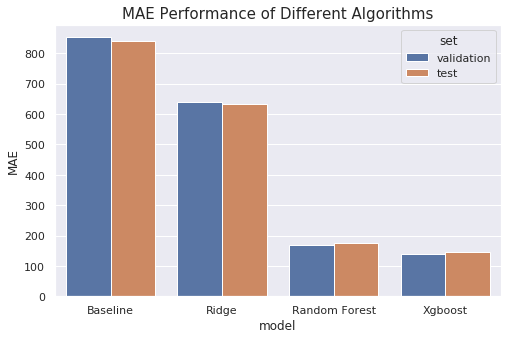

In [35]:
# 각 모델의 mae 성능 비교 -> 낮을 수록 좋음
plt.figure(figsize=(8,5))
sns.barplot(x='model', y='MAE', data=performance, hue='set')
plt.title('MAE Performance of Different Algorithms', fontsize=15)

Text(0.5, 1.0, 'R2 Score Performance of Different Algorithms')

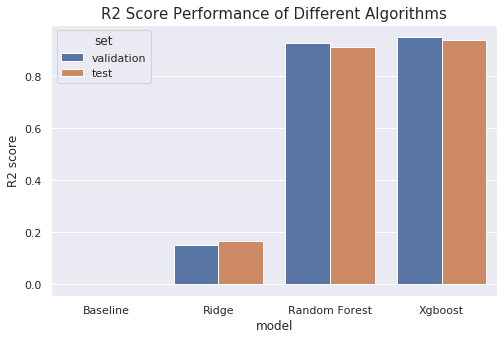

In [36]:
# 각 모델의 r2 score 성능 비교 -> 높을 수록 좋음
plt.figure(figsize=(8,5))
sns.barplot(x='model', y='R2 score', data=performance, hue='set')
plt.title('R2 Score Performance of Different Algorithms', fontsize=15)

## **4. Hyperparameter tuning**

*Xgboost의 성능이 가장 높았으므로 Xgboost 모델에 대해서만 수행*

In [37]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
                 ('model', TransformedTargetRegressor(
                     regressor=XGBRegressor(random_state=6),
                     func=np.log1p,
                     inverse_func=np.expm1))
                 ])

dists = {'model__regressor__n_estimators': range(50, 1050, 100),
         'model__regressor__max_depth': range(1, 18, 4),
         'model__regressor__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]}

clf = RandomizedSearchCV(pipe,
                         param_distributions=dists,
                         n_iter=50,
                         cv=3,
                         scoring='r2',
                         n_jobs=-1)

clf.fit(X_train, y_train)

[17:13:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('model',
                                              TransformedTargetRegressor(check_inverse=True,
                                                                         func=<ufunc 'log1p'>,
                                                                         inverse_func=<ufunc 'expm1'>,
                                                                         regressor=XGBRegressor(base_score=0.5,
                                                                                                booster='gbtree',
                                                                                                colsample_bylevel=1,
                                                                                                colsample_bynode=1,
                                                                                                colsam

In [38]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('R2 score: ', clf.best_score_)

최적 하이퍼파라미터:  {'model__regressor__n_estimators': 750, 'model__regressor__max_depth': 5, 'model__regressor__learning_rate': 0.1}
R2 score:  0.9454367833075739


In [39]:
final_model = clf.best_estimator_

final_pred = final_model.predict(X_test)

print('최종 모델의 Train R2 score:', final_model.score(X_train, y_train))
print('최종 모델의 Validation R2 score:', final_model.score(X_val, y_val))
print('최종 모델의 Test MAE:', mean_absolute_error(y_test, final_pred))
print('최종 모델의 Test R2 score:', r2_score(y_test, final_pred))

최종 모델의 Train R2 score: 0.972518105566528
최종 모델의 Validation R2 score: 0.9529099731428994
최종 모델의 Test MAE: 148.14413369677376
최종 모델의 Test R2 score: 0.9397732378050255


## **6. 모델 해석**

#### *1) PDP(Partial Dependence Plot)을 통해 각 특성의 타겟에 대한 영향 시각화*

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


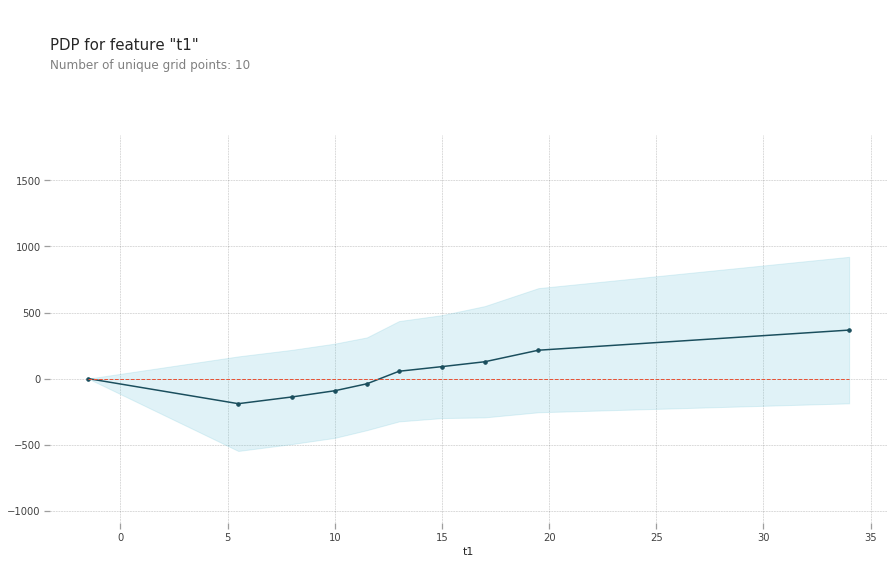

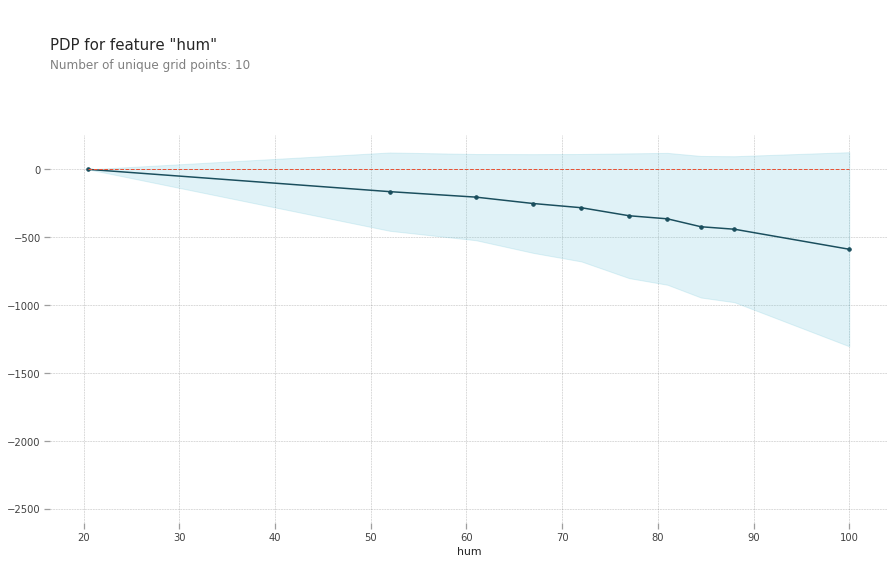

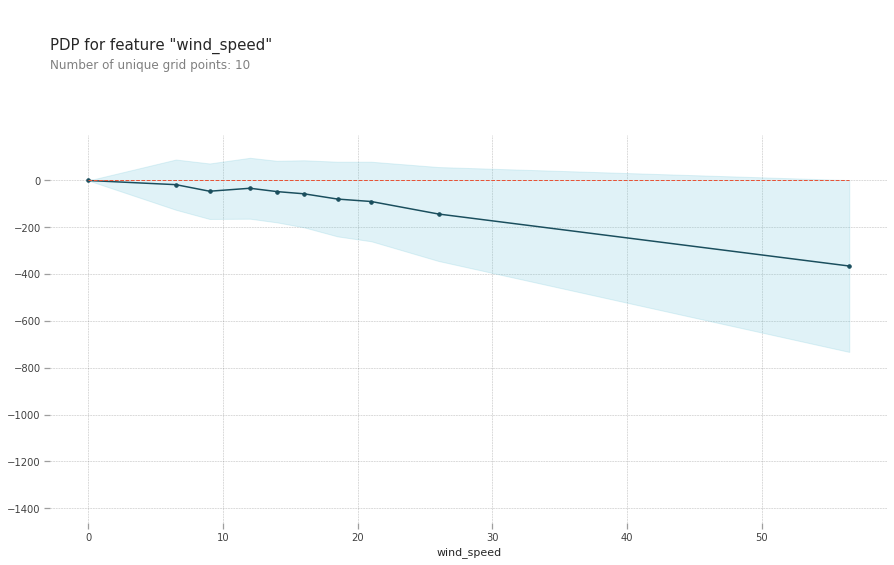

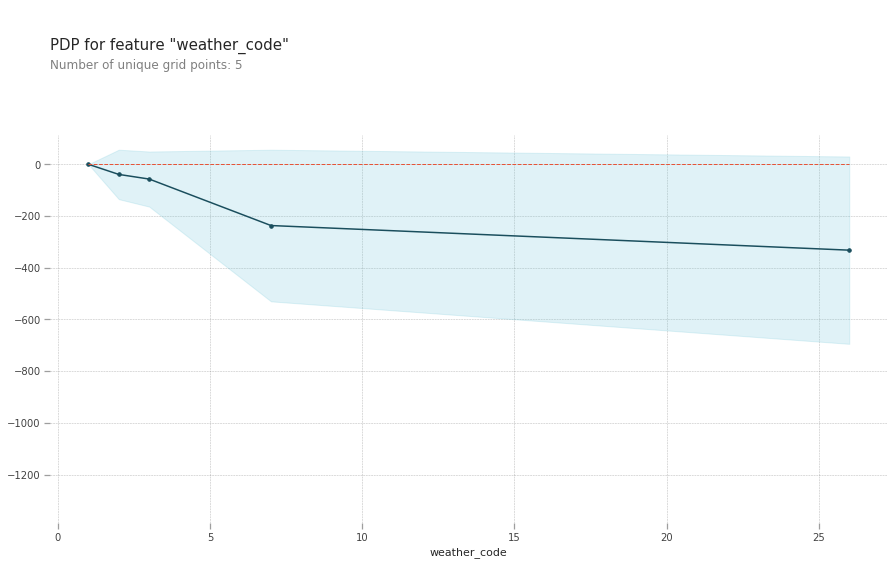

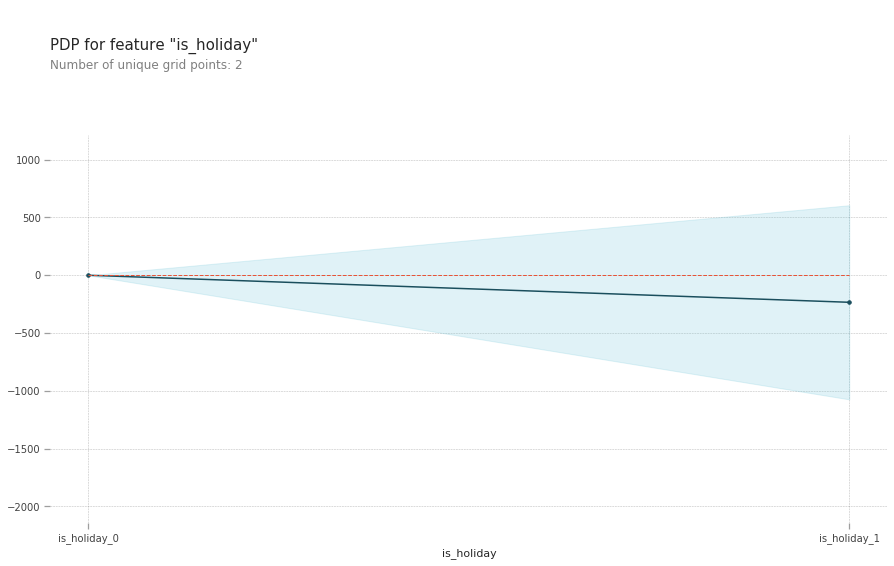

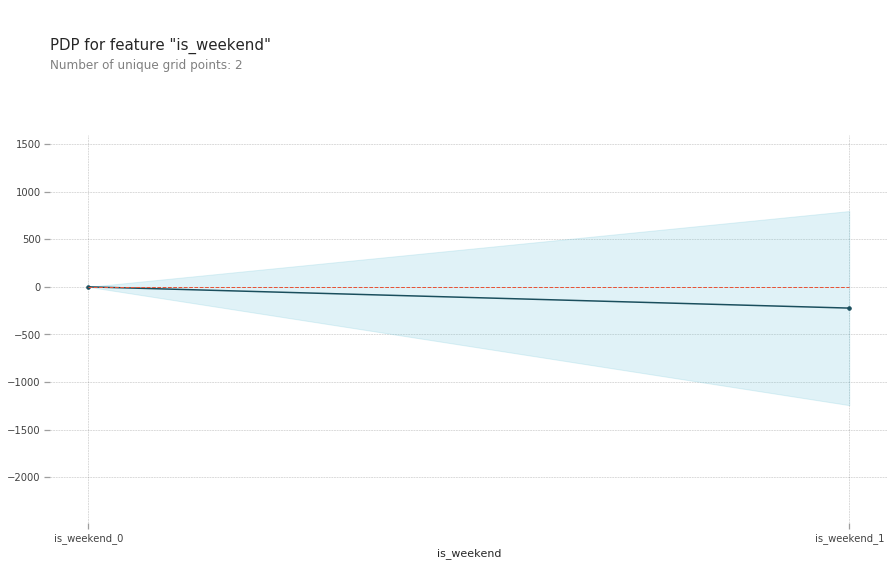

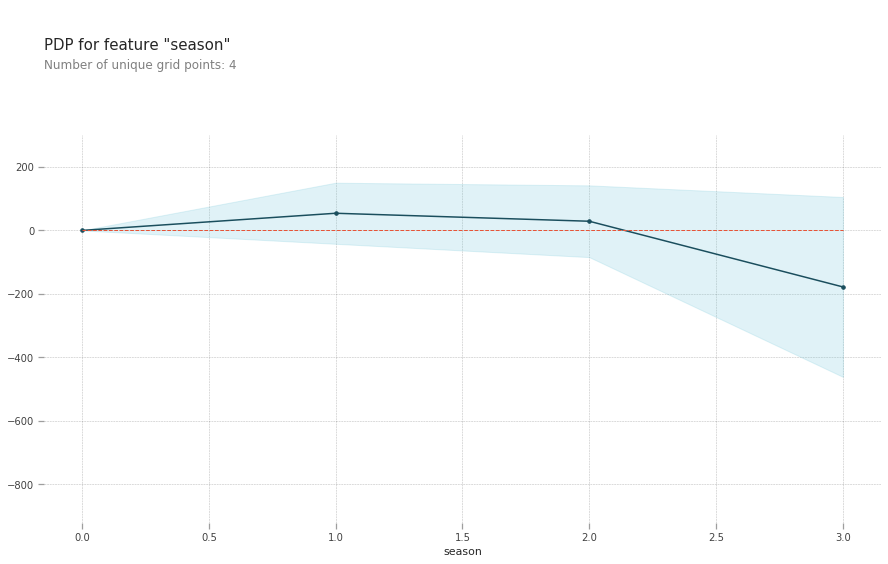

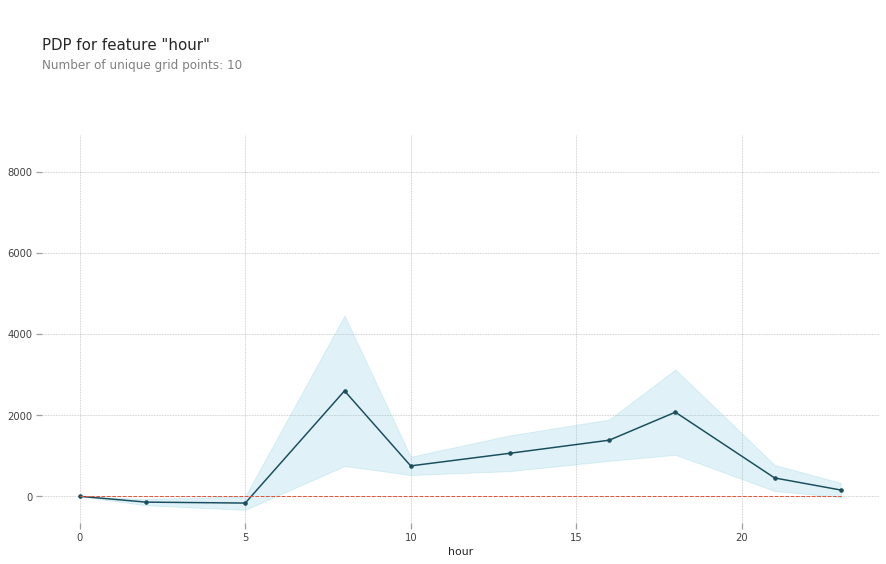

In [40]:
for i in X_train.columns:
  isolated = pdp_isolate(model=final_model,
                         dataset = X_train,
                         model_features = X_train.columns,
                         feature=i)
  pdp_plot(isolated, feature_name=i)

#### *2) Shapley value 확인해보기* 
> 변수의 기여도를 중심으로 설명

In [41]:
y_train2 = np.log1p(y_train)
shap_model = XGBRegressor(random_state=6, n_estimators=950, max_depth=5, learning_rate=0.05)
shap_model.fit(X_train, y_train2)
shap_pred = shap_model.predict(X_test)

[17:15:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


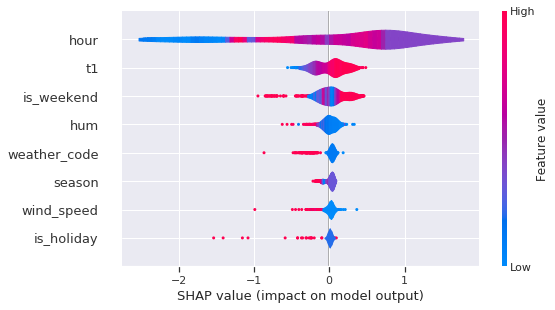

In [42]:
# 빨간색을 띌수록 타겟에 대해 양의 영향력, 파란색을 띌수록 음의 영향력
explainer = shap.TreeExplainer(shap_model)

shap.initjs()
shap_values = explainer.shap_values(X_train.iloc[4000:5000])
shap.summary_plot(shap_values, X_train.iloc[4000:5000], plot_type='violin')

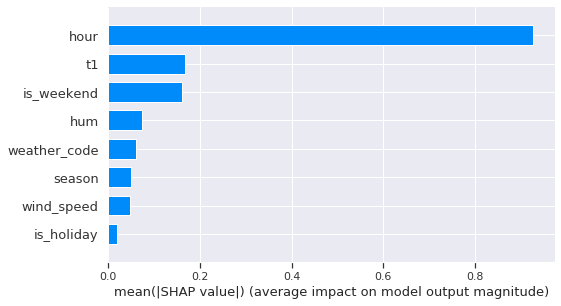

In [43]:
# 큰 영향력을 보일수록 타겟과의 관계성이 높음
shap.summary_plot(shap_values, X_train.iloc[4000:5000], plot_type='bar')

#### *3) Permutation importance 확인*
> 모델의 성능 감소를 중심으로 설명

In [44]:
permuter = PermutationImportance(final_model,
                                 scoring='r2',
                                 n_iter=5,
                                 random_state=2)

permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('model',
                                                 TransformedTargetRegressor(check_inverse=True,
                                                                            func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>,
                                                                            regressor=XGBRegressor(base_score=0.5,
                                                                                                   booster='gbtree',
                                                                                                   colsample_bylevel=1,
                                                                                                   colsample_bynode=1,
                                                                                  

In [45]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

wind_speed      0.015936
is_holiday      0.020260
weather_code    0.028784
season          0.034544
hum             0.077753
t1              0.110644
is_weekend      0.379577
hour            1.504665
dtype: float64

In [46]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.5047 ± 0.0695,hour
0.3796 ± 0.0347,is_weekend
0.1106 ± 0.0156,t1
0.0778 ± 0.0083,hum
0.0345 ± 0.0030,season
0.0288 ± 0.0043,weather_code
0.0203 ± 0.0033,is_holiday
0.0159 ± 0.0032,wind_speed
